[*********************100%***********************]  1 of 1 completed


Training Accuracy: 0.7341040462427746
Testing Accuracy: 0.7586206896551724


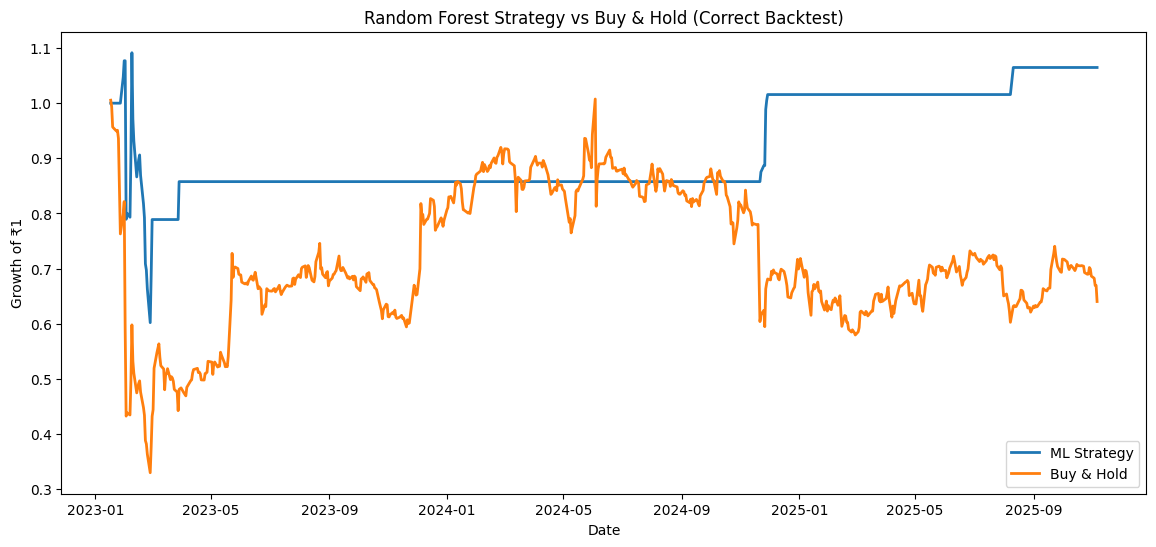

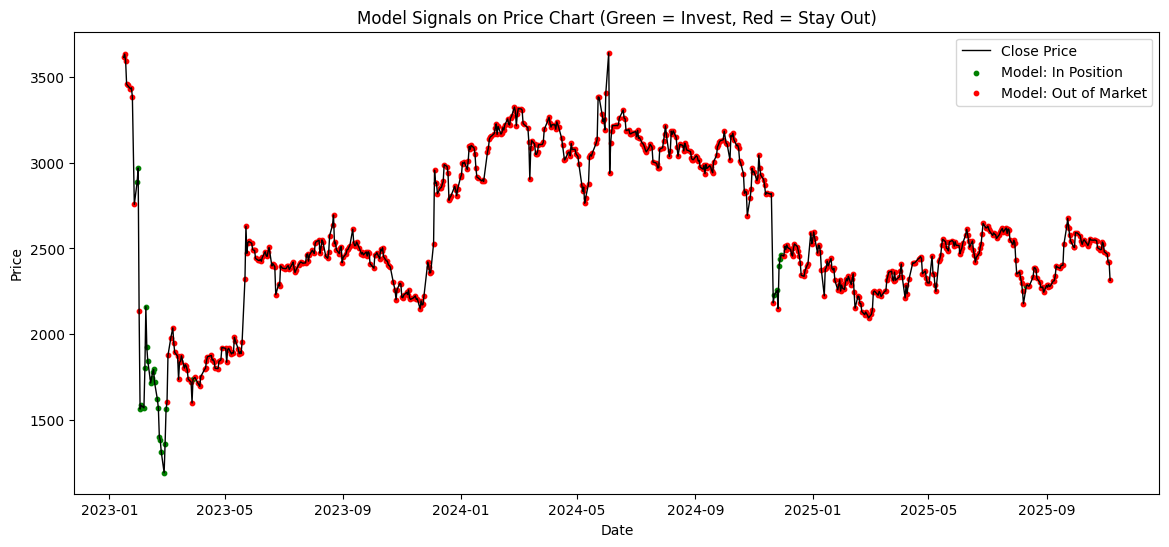

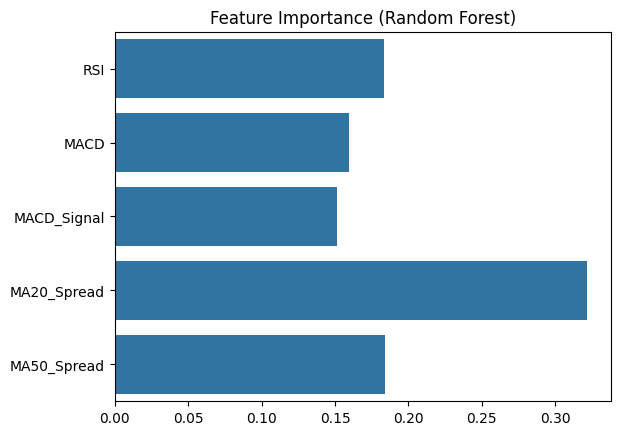

In [5]:
import pandas as pd
import yfinance as yf
from ta.momentum import RSIIndicator
from ta.trend import MACD
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load & Prepare Data
# -----------------------------
ticker = "ADANIENT.NS"
df = yf.download(ticker, period="3y", auto_adjust=True)

# Fix MultiIndex Columns
df.columns = df.columns.get_level_values(0)
df = df.reset_index()

# -----------------------------
# Technical Indicators
# -----------------------------
df["RSI"] = RSIIndicator(df["Close"], window=14).rsi()

macd = MACD(df["Close"], window_slow=26, window_fast=12, window_sign=9)
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()

df["MA20"] = df["Close"].rolling(20).mean()
df["MA50"] = df["Close"].rolling(50).mean()

df["MA20_Spread"] = (df["Close"] - df["MA20"]) / df["MA20"]
df["MA50_Spread"] = (df["Close"] - df["MA50"]) / df["MA50"]

# -----------------------------
# Target Variable (Predict ≥ 1% next-day rise)
# -----------------------------
df["Future_Close"] = df["Close"].shift(-1)
df["Target"] = (df["Future_Close"] > df["Close"] * 1.01).astype(int)

df.dropna(inplace=True)

# -----------------------------
# ML Dataset
# -----------------------------
features = ["RSI", "MACD", "MACD_Signal", "MA20_Spread", "MA50_Spread"]
X = df[features]
y = df["Target"]

# Time-series split (no shuffle)
split = int(len(X) * 0.75)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# -----------------------------
# Random Forest Model
# -----------------------------
model = RandomForestClassifier(
    n_estimators=150,
    max_depth=5,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42
)
model.fit(X_train, y_train)

print("Training Accuracy:", model.score(X_train, y_train))
print("Testing Accuracy:", model.score(X_test, y_test))

# -----------------------------
# Backtesting (Correct Logic)
# -----------------------------
df["Predicted"] = model.predict(X)

# Use prediction *next day* (shift)
df["Position"] = df["Predicted"].shift(1).fillna(0)

df["Market_Return"] = df["Close"].pct_change()
df["Strategy_Return"] = df["Position"] * df["Market_Return"]

df["Strategy_Cumulative"] = (1 + df["Strategy_Return"]).cumprod()
df["BuyHold_Cumulative"] = (1 + df["Market_Return"]).cumprod()

# -----------------------------
# Plot Strategy vs Buy & Hold
# -----------------------------
plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["Strategy_Cumulative"], label="ML Strategy", linewidth=2)
plt.plot(df["Date"], df["BuyHold_Cumulative"], label="Buy & Hold", linewidth=2)
plt.title("Random Forest Strategy vs Buy & Hold (Correct Backtest)")
plt.xlabel("Date")
plt.ylabel("Growth of ₹1")
plt.legend()
plt.show()

# -----------------------------
# Signal Plot (When Model Takes / Avoids Position)
# -----------------------------
plt.figure(figsize=(14,6))

plt.plot(df["Date"], df["Close"], label="Close Price", color="black", linewidth=1)

# Highlight Buy/Hold Regions
buy_mask = df["Position"] == 1
sell_mask = df["Position"] == 0

plt.scatter(df["Date"][buy_mask], df["Close"][buy_mask],
            color="green", label="Model: In Position", s=10)

plt.scatter(df["Date"][sell_mask], df["Close"][sell_mask],
            color="red", label="Model: Out of Market", s=10)

plt.title("Model Signals on Price Chart (Green = Invest, Red = Stay Out)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# -----------------------------
# Feature Importance
# -----------------------------
sns.barplot(x=model.feature_importances_, y=features)
plt.title("Feature Importance (Random Forest)")
plt.show()
